In [1]:
import xml.etree.ElementTree as et 
import os
import pandas as pd
import cv2
import numpy as np
import torch

In [2]:
file_name="AisazuNihaIrarenai"

In [3]:
annotation_path:str="/home/data/Manga109s/annotations/" #AisazuNihaIrarenai" #.xml

In [4]:
#image_folder=os.path.join(annotation_path,file_name+"/")
xml_path=os.path.join(annotation_path,"{}.xml".format(file_name))

In [5]:
xtree = et.parse(xml_path)
xroot = xtree.getroot()

In [6]:
def format_bounding_data(xml_path:str):
    xtree = et.parse(xml_path)
    xroot = xtree.getroot()
    all_manga=pd.DataFrame()
    for tee in xroot[1]:

        all_lines=[]
        all_attr=[]
        for rank in tee.iter('text'):

            all_lines.append(rank.attrib)
            all_attr.append(tee.attrib)
        results=pd.DataFrame(all_lines)
        results=results.join(pd.DataFrame(all_attr))
        results["manga"]=file_name
        all_manga=all_manga.append(results)
    all_manga["xmin"]=pd.to_numeric(all_manga.
                                    xmin)
    all_manga["ymin"]=pd.to_numeric(all_manga.ymin)
    all_manga["ymax"]=pd.to_numeric(all_manga.ymax)
    all_manga["xmax"]=pd.to_numeric(all_manga.xmax)
    all_manga["index"]=pd.to_numeric(all_manga["index"])
    return all_manga.rename(columns={"width":"page_width","height":"page_height","index":"page_num",})
    
    
    

In [7]:
results=format_bounding_data(xml_path)
results["width"]=results["xmax"]-results["xmin"]
results["height"]=results["ymax"]-results["ymin"]
results["path"]="/home/data/Manga109s/images/AisazuNihaIrarenai/"

**Create train loader for loading into fast rcnn **

In [8]:
from torch.utils.data import Dataset, DataLoader

In [9]:
class MangaDataset(Dataset):
    
    def __init__(self,dataframe):
        
        super().__init__()
        
        self.df=dataframe
        self._length=len(dataframe["page_num"].unique())
        self._min_page=dataframe["page_num"].min()
    def __len__(self):
        return self._length
    
    
    def __getitem__(self,index:int):
        relevant_lines=self.df[self.df.page_num==(index+self._min_page)]
        
        img_id=relevant_lines["page_num"].values[0]
        img_dir=relevant_lines["path"].values[0]
        id_formatted:str='{:03d}'.format(img_id)
        img_path_full:str=os.path.join(img_dir,id_formatted)+"{}".format(".jpg")
        print(img_path_full)
        image=cv2.imread(img_path_full,cv2.IMREAD_COLOR).astype(np.float32)
        image/=255
       # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        imshow(image)
        #image_element
        
        boxes = relevant_lines[["xmin","ymin","xmax","ymax"]].values
        labels = torch.ones((relevant_lines.shape[0],), dtype=torch.int64)
        
        target={}
        target["boxes"]=boxes
        target["labels"]=labels
        target["image_id"]=torch.tensor([index])
        
        return image,target, img_id
           
        
        
        

In [10]:
%%time


UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [11]:
np.zeros((1,10))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [12]:
from matplotlib.pyplot import imshow
%matplotlib inline


In [13]:
%%time
results.iloc[1]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 656 µs


manga                                       AisazuNihaIrarenai
id                                                    00000983
xmin                                                       384
ymin                                                        62
xmax                                                       446
ymax                                                       172
page_num                                                     2
page_width                                                1654
page_height                                               1170
width                                                       62
height                                                     110
path           /home/data/Manga109s/images/AisazuNihaIrarenai/
Name: 1, dtype: object

In [14]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


In [206]:
import torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).cuda()

In [50]:
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features


In [59]:

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes).cuda()

In [52]:


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



/home/data/Manga109s/images/AisazuNihaIrarenai/002.jpg


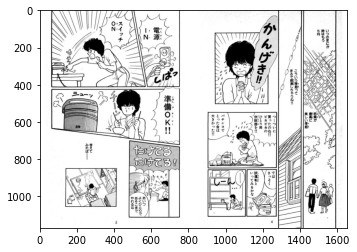

In [15]:

d=MangaDataset(results)
what=DataLoader(d)
images,targets,image_ids=next(iter(what))




In [54]:
images = list(img.to(device) for img in images)

In [55]:
images_temp.shape

torch.Size([1, 3, 1654, 1170])

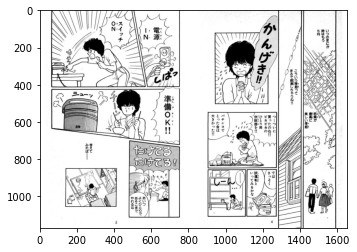

In [220]:
model.eval()
outputs=None
with torch.no_grad():
    outputs=model(images_temp.cuda())


In [215]:
outputs

[{'boxes': tensor([[178.7653, 289.7594, 700.0000, 673.5140],
          [  0.0000, 461.4016, 700.0000, 593.3365],
          [359.1775,   0.0000, 700.0000, 903.7491],
          [ 62.3850, 505.4281, 700.0000, 774.8193],
          [333.1257,   0.0000, 700.0000, 221.8113]], device='cuda:0'),
  'labels': tensor([67, 67,  3, 67,  3], device='cuda:0'),
  'scores': tensor([0.9739, 0.8937, 0.7305, 0.2691, 0.1010], device='cuda:0')}]

In [217]:
the_predictions

array([[178.76529 , 289.75943 , 700.      , 673.514   ],
       [  0.      , 461.40158 , 700.      , 593.33655 ],
       [359.17746 ,   0.      , 700.      , 903.74915 ],
       [ 62.385033, 505.42807 , 700.      , 774.81934 ],
       [333.1257  ,   0.      , 700.      , 221.8113  ]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'boxes': tensor([[102.1995, 559.5914, 118.5361, 595.8201],
        [148.8187, 230.4403, 164.4773, 266.9774],
        [353.1513, 449.3348, 368.5245, 482.1578],
        [ 91.7323, 523.0024, 171.8670, 616.7958],
        [343.3895, 410.6414, 418.2355, 504.5786],
        [ 13.2003,  12.5022, 408.0610, 448.2753],
        [102.6149, 549.3934, 117.4398, 569.8246],
        [136.3332, 197.6367, 206.2062, 285.8517],
        [341.9112, 412.4609, 415.1447, 502.7057],
        [ 11.2235,   9.7356, 405.4214, 453.3989],
        [ 23.7315, 155.4807, 411.1787, 676.0331],
        [ 93.7227, 524.6492, 172.5389, 616.1512],
        [352.7504, 452.4305, 363.7342, 475.9141],
        [147.8917, 218.9709, 162.8003, 243.9310],
        [ 90.1441, 524.1902, 173.6112, 618.0388],
        [ 13.7153,  11.9985, 407.6472, 453.0732],
        [147.6493, 232.9725, 160.1604, 258.2331],
        [105.2941, 549.4841, 115.9511, 563.3849],
        [354.9886, 453.7062, 367.9012, 467.2972],
        [321.7864, 442.3111, 328.7173, 4

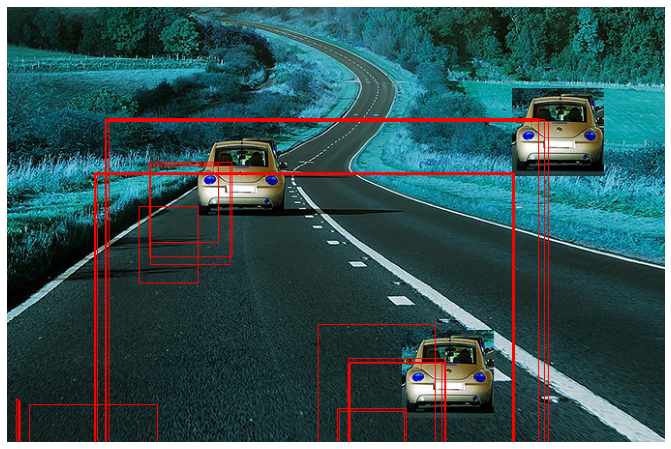

In [275]:


image_path_person="driveleft2.jpg"

image_person=cv2.imread(image_path_person,cv2.IMREAD_COLOR).astype(np.float32)
image_person/=255
image_person=torch.Tensor(image_person).T
image_person_shape=(1,image_person.shape[0],image_person.shape[1],image_person.shape[2])

image_person=image_person.view(image_person_shape)
from matplotlib import pyplot as plt 


model.eval()
#outputs=None
#with torch.no_grad():
#    outputs=model(image_person.cuda())

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
img_specified= image_person[0].cpu().detach().numpy()#images_temp[0].cpu().detach().numpy()

the_predictions=outputs[0]["boxes"].cpu().detach().numpy()

print(outputs[0])
for box,conf in zip(the_predictions,outputs[0]["scores"]):
   # if conf <.2:
    #    continue
    box=box.astype(int)
    #box=box.reshape((2,2)).T.reshape((4,))
    point1=(box[0], box[2])
    point2=(box[1], box[3])
    color=(220,0,0)
    #print(box)
    cv2.rectangle(img_specified.T,point1,point2,color)
    #print(img_specified[:,point2[1]:point1[1],point2[0]:point1[0]].shape)
ax.set_axis_off()
ax.imshow(img_specified.T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'boxes': tensor([[102.1995, 559.5914, 118.5361, 595.8201],
        [148.8187, 230.4403, 164.4773, 266.9774],
        [353.1513, 449.3348, 368.5245, 482.1578],
        [ 91.7323, 523.0024, 171.8670, 616.7958],
        [343.3895, 410.6414, 418.2355, 504.5786],
        [ 13.2003,  12.5022, 408.0610, 448.2753],
        [102.6149, 549.3934, 117.4398, 569.8246],
        [136.3332, 197.6367, 206.2062, 285.8517],
        [341.9112, 412.4609, 415.1447, 502.7057],
        [ 11.2235,   9.7356, 405.4214, 453.3989],
        [ 23.7315, 155.4807, 411.1787, 676.0331],
        [ 93.7227, 524.6492, 172.5389, 616.1512],
        [352.7504, 452.4305, 363.7342, 475.9141],
        [147.8917, 218.9709, 162.8003, 243.9310],
        [ 90.1441, 524.1902, 173.6112, 618.0388],
        [ 13.7153,  11.9985, 407.6472, 453.0732],
        [147.6493, 232.9725, 160.1604, 258.2331],
        [105.2941, 549.4841, 115.9511, 563.3849],
        [354.9886, 453.7062, 367.9012, 467.2972],
        [321.7864, 442.3111, 328.7173, 4

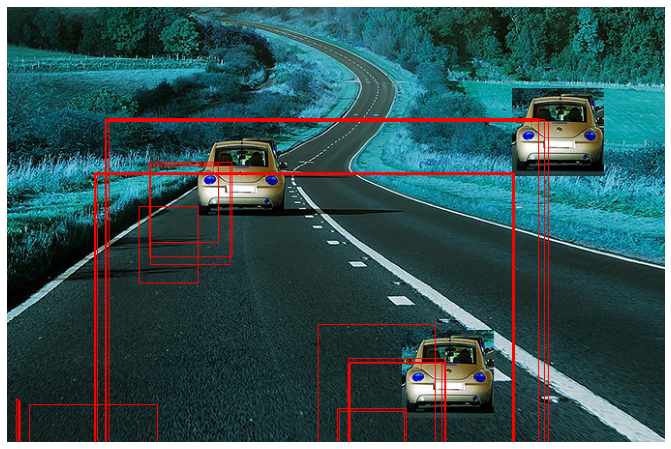

In [281]:


image_path_person="driveleft2.jpg"

image_person=cv2.imread(image_path_person,cv2.IMREAD_COLOR).astype(np.float32)
image_person/=255
image_person=torch.Tensor(image_person).T
image_person_shape=(1,image_person.shape[0],image_person.shape[1],image_person.shape[2])

image_person=image_person.view(image_person_shape)
from matplotlib import pyplot as plt 


model.eval()
outputs=None
with torch.no_grad():
    outputs=model(image_person.cuda())

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
img_specified= image_person[0].cpu().detach().numpy()#images_temp[0].cpu().detach().numpy()

the_predictions=outputs[0]["boxes"].cpu().detach().numpy()

print(outputs[0])
for box,conf in zip(the_predictions,outputs[0]["scores"]):
   # if conf <.2:
    #    continue
    box=box.astype(int)
    #box=box.reshape((2,2)).T.reshape((4,))
    point1=(box[0], box[2])
    point2=(box[1], box[3])
    color=(220,0,0)
    #print(box)
    cv2.rectangle(img_specified.T,point1,point2,color)
    #print(img_specified[:,point2[1]:point1[1],point2[0]:point1[0]].shape)
ax.set_axis_off()
ax.imshow(img_specified.T)

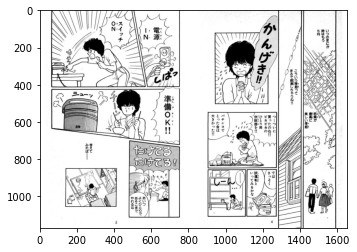

In [244]:
d=MangaDataset(results)
what=DataLoader(d)
images,targets,image_ids=next(iter(what))
images_spec=images[0].T



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.9907, device='cuda:0')
(646, 1053)
tensor(0.1632, device='cuda:0')
(823, 1318)
tensor(0.1442, device='cuda:0')
(146, 228)
tensor(0.1416, device='cuda:0')
(794, 1327)


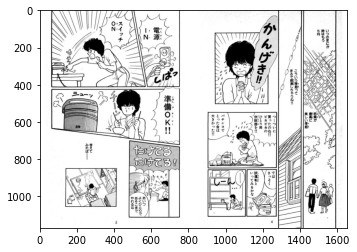

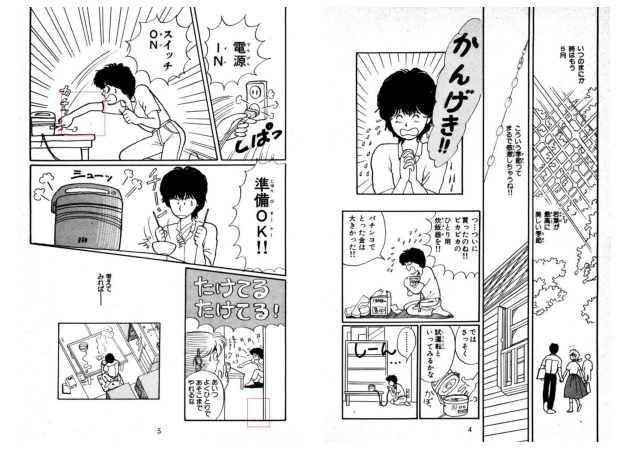

In [254]:

d=MangaDataset(results)
what=DataLoader(d)
images,targets,image_ids=next(iter(what))
images_spec=images[0].T
images_temp=images_spec.view((1,3,1654,1170))
from matplotlib import pyplot as plt 
model.eval()
outputs=None
with torch.no_grad():
    outputs=model(images_temp.cuda())

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
img_specified= images_temp[0].cpu().detach().numpy()#images_temp[0].cpu().detach().numpy()

the_predictions=outputs[0]["boxes"].cpu().detach().numpy()
model.eval()
outputs=None
with torch.no_grad():
    outputs=model(image_person.cuda())

for box,conf in zip(the_predictions,outputs[0]["scores"]):
    if conf < .10:
        continue
    print(conf)
    box=box.astype(int)
    point1=(box[0], box[1])
    point2=(box[2], box[3])
    color=(220,0,0)
    #print(box)
    #print(img_specified.shape)
    #img_specified[:,point1[0]:point2[0],point1[1]:point2[1]]=0
    print(point1)
    
    cv2.rectangle(img_specified.T,point1,point2,color)
    #print(img_specified[:,point2[1]:point1[1],point2[0]:point1[0]].shape)
ax.set_axis_off()
ax.imshow(img_specified.T)

In [146]:
img_specified.T.shape

(1170, 1654, 3)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
img_specified=images_temp[0].cpu().detach().numpy()

ground_truth=targets["boxes"].cpu().detach().numpy()
for box in ground_truth[0]:
   
    point1=(box[0], box[1])
    point2=(box[2], box[3])
    color=(220,0,0)
    print(box)
    #img_specified[:,point1[0]:point2[0],point1[1]:point2[1]]=0
    cv2.rectangle(img_specified.T,point1,point2,color)
ax.set_axis_off()
ax.imshow(img_specified.T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


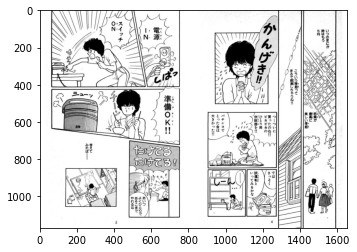

In [158]:
img_specified=images_temp[0].cpu().detach().numpy()
image_whut=np.array(img_specified)
color=(220,200,20)
cv2.rectangle(img_specified,(500,800),(500,800),color)
imshow(img_specified.T)


In [ ]:
img_specified-